In [62]:
import cv2 
import torch

In [63]:
torch.cuda.current_device()
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [64]:
import os
os.getcwd()

'/home/tianbai/P1_Facial_Keypoints'

In [65]:

import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:

import torch
import torch.nn as nn
import torch.nn.functional as F

from models import Net

net = Net()
print(net)
net.cuda()

Net(
  (conv1): Conv2d (1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d (32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv3): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.6)
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (fc1): Linear(in_features=80000, out_features=300)
  (fc1_bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True)
  (dropout2): Dropout(p=0.5)
  (fc2): Linear(in_features=300, out_features=136)
)


Net(
  (conv1): Conv2d (1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d (32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv3): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.6)
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (fc1): Linear(in_features=80000, out_features=300)
  (fc1_bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True)
  (dropout2): Dropout(p=0.5)
  (fc2): Linear(in_features=300, out_features=136)
)

In [133]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor

crop = 224

data_transform = transforms.Compose([Rescale(250),
                                    RandomCrop(crop),
                                    Normalize(crop),
                                    ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [134]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='training_frames_keypoints.csv',
                                             root_dir='/home/tianbai/P1_Facial_Keypoints/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))


for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())
    print (sample['keypoints'][0:5])

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])

-0.5096  0.1771
-0.4843  0.2783
-0.4589  0.3289
-0.4082  0.4427
-0.3701  0.5186
[torch.DoubleTensor of size 5x2]

1 torch.Size([1, 224, 224]) torch.Size([68, 2])

-0.6135  0.0011
-0.5851  0.1148
-0.5566  0.2427
-0.5282  0.3564
-0.4713  0.5128
[torch.DoubleTensor of size 5x2]

2 torch.Size([1, 224, 224]) torch.Size([68, 2])

-0.2826 -0.4436
-0.2826 -0.3387
-0.2826 -0.2207
-0.2826 -0.1158
-0.2563  0.0022
[torch.DoubleTensor of size 5x2]

3 torch.Size([1, 224, 224]) torch.Size([68, 2])

-0.3965 -0.5476
-0.4279 -0.3908
-0.4279 -0.2549
-0.4279 -0.1295
-0.4279 -0.0040
[torch.DoubleTensor of size 5x2]



In [135]:
# load training data in batches
batch_size = 10
train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


In [136]:

test_dataset = FacialKeypointsDataset(csv_file='test_frames_keypoints.csv',
                                      root_dir='/home/tianbai/P1_Facial_Keypoints/data/test/',
                                      transform=data_transform)

In [137]:
print (test_dataset[0]['keypoints'].size())

torch.Size([68, 2])


In [138]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Test the model on a sample before training



In [139]:
# test the model on a batch of test images
from torch.autograd import Variable
def net_sample_output():
    criterion = nn.L1Loss().cuda()
    running_loss = 0.0
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        images = images.cuda(async=True)
        
        key_pts = key_pts.cuda(async=True)
        key_pts = Variable(key_pts)
        key_pts = key_pts.type(torch.cuda.FloatTensor)
        
        
        # wrap images in a torch Variable
        # key_pts do not need to be wrapped until they are used for training
        images = Variable(images)

        # convert images to FloatTensors
        images = images.type(torch.cuda.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        loss = criterion(output_pts, key_pts)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        key_pts = key_pts.view(key_pts.size()[0], 68, -1)
        
        running_loss += loss.data[0]/1000
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts, running_loss
            

In [140]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts, _ = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


In [141]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


# Visualize the prediction points without training

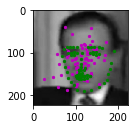

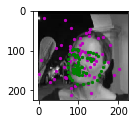

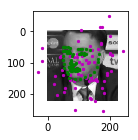

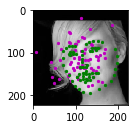

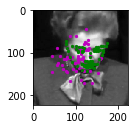

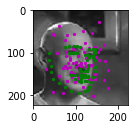

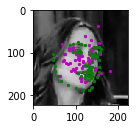

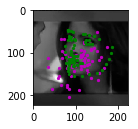

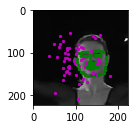

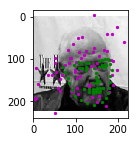

In [142]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.cpu().numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        #if i==0:
           # print (predicted_key_pts)
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*112+112
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*112+112
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
          
        #plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training


---

In [145]:

import torch.optim as optim

criterion = nn.L1Loss().cuda()

optimizer = optim.Adam(params=net.parameters(),lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [146]:
def train_net(n_epochs):
    loss_log_tr =[]
    loss_log_te = []
    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            
            # wrap them in a torch Variable
            images, key_pts = Variable(images), Variable(key_pts)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.data[0]
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                loss_log_tr.append(running_loss/1000)
                running_loss = 0.0
                _, _, _, test_loss = net_sample_output()
                loss_log_te.append(test_loss)
            #requests.request("POST", "https://nebula.udacity.com/api/v1/remote/keep-alive", headers={'Authorization': "STAR " + token})
    print('Finished Training')
    return loss_log_tr,loss_log_te


In [147]:
# train your network
n_epochs = 200 # start small, and increase when you've decided on your model structure and hyperparams

train_loss, test_loss= train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.0032075287997722626
Epoch: 1, Batch: 20, Avg. Loss: 0.002559305265545845
Epoch: 1, Batch: 30, Avg. Loss: 0.0024381337612867354
Epoch: 1, Batch: 40, Avg. Loss: 0.0023155714869499207
Epoch: 1, Batch: 50, Avg. Loss: 0.0022940216362476347
Epoch: 1, Batch: 60, Avg. Loss: 0.002134523391723633
Epoch: 1, Batch: 70, Avg. Loss: 0.0020956821590662
Epoch: 1, Batch: 80, Avg. Loss: 0.0020586831867694857
Epoch: 1, Batch: 90, Avg. Loss: 0.002097930535674095
Epoch: 1, Batch: 100, Avg. Loss: 0.0018897458612918854
Epoch: 1, Batch: 110, Avg. Loss: 0.0019080630689859391
Epoch: 1, Batch: 120, Avg. Loss: 0.0018134830594062805
Epoch: 1, Batch: 130, Avg. Loss: 0.0018199163675308228
Epoch: 1, Batch: 140, Avg. Loss: 0.0018980615437030792
Epoch: 1, Batch: 150, Avg. Loss: 0.0019663378447294234
Epoch: 1, Batch: 160, Avg. Loss: 0.001844930425286293
Epoch: 1, Batch: 170, Avg. Loss: 0.0018255015313625336
Epoch: 1, Batch: 180, Avg. Loss: 0.0016843569725751876
Epoch: 1, Batch: 190, Avg.

Epoch: 5, Batch: 160, Avg. Loss: 0.0008422919437289238
Epoch: 5, Batch: 170, Avg. Loss: 0.0008873991072177887
Epoch: 5, Batch: 180, Avg. Loss: 0.0008580745607614517
Epoch: 5, Batch: 190, Avg. Loss: 0.000996258683502674
Epoch: 5, Batch: 200, Avg. Loss: 0.0008579144328832626
Epoch: 5, Batch: 210, Avg. Loss: 0.001008162260055542
Epoch: 5, Batch: 220, Avg. Loss: 0.0009678428322076797
Epoch: 5, Batch: 230, Avg. Loss: 0.0011324180364608765
Epoch: 5, Batch: 240, Avg. Loss: 0.0009545847773551941
Epoch: 5, Batch: 250, Avg. Loss: 0.000934217669069767
Epoch: 5, Batch: 260, Avg. Loss: 0.0009266060069203376
Epoch: 5, Batch: 270, Avg. Loss: 0.0008851481825113296
Epoch: 5, Batch: 280, Avg. Loss: 0.0009243983998894692
Epoch: 5, Batch: 290, Avg. Loss: 0.0009725893512368202
Epoch: 5, Batch: 300, Avg. Loss: 0.0009357969760894775
Epoch: 5, Batch: 310, Avg. Loss: 0.0008928758352994919
Epoch: 5, Batch: 320, Avg. Loss: 0.0009249272495508194
Epoch: 5, Batch: 330, Avg. Loss: 0.0009512540027499199
Epoch: 5, Bat

Epoch: 9, Batch: 300, Avg. Loss: 0.0008984102308750153
Epoch: 9, Batch: 310, Avg. Loss: 0.0007585853673517704
Epoch: 9, Batch: 320, Avg. Loss: 0.0008599682338535786
Epoch: 9, Batch: 330, Avg. Loss: 0.0009782637916505336
Epoch: 9, Batch: 340, Avg. Loss: 0.0008231330737471581
Epoch: 10, Batch: 10, Avg. Loss: 0.0008046104609966278
Epoch: 10, Batch: 20, Avg. Loss: 0.0009544302523136139
Epoch: 10, Batch: 30, Avg. Loss: 0.0008788429349660873
Epoch: 10, Batch: 40, Avg. Loss: 0.0009621639251708985
Epoch: 10, Batch: 50, Avg. Loss: 0.0008316751420497894
Epoch: 10, Batch: 60, Avg. Loss: 0.0008998191654682159
Epoch: 10, Batch: 70, Avg. Loss: 0.0008003387153148651
Epoch: 10, Batch: 80, Avg. Loss: 0.0007711805328726769
Epoch: 10, Batch: 90, Avg. Loss: 0.0008686410188674927
Epoch: 10, Batch: 100, Avg. Loss: 0.0008923435732722283
Epoch: 10, Batch: 110, Avg. Loss: 0.0009672141075134277
Epoch: 10, Batch: 120, Avg. Loss: 0.0009887803867459296
Epoch: 10, Batch: 130, Avg. Loss: 0.0009252385534346104
Epoch:

Epoch: 14, Batch: 80, Avg. Loss: 0.0008739173635840416
Epoch: 14, Batch: 90, Avg. Loss: 0.0009894794598221779
Epoch: 14, Batch: 100, Avg. Loss: 0.0009565669894218445
Epoch: 14, Batch: 110, Avg. Loss: 0.0009102307185530663
Epoch: 14, Batch: 120, Avg. Loss: 0.0008367070667445659
Epoch: 14, Batch: 130, Avg. Loss: 0.0009415944144129753
Epoch: 14, Batch: 140, Avg. Loss: 0.0008403868786990643
Epoch: 14, Batch: 150, Avg. Loss: 0.0008669542297720909
Epoch: 14, Batch: 160, Avg. Loss: 0.0009740724042057991
Epoch: 14, Batch: 170, Avg. Loss: 0.0008884850367903709
Epoch: 14, Batch: 180, Avg. Loss: 0.0008575114458799362
Epoch: 14, Batch: 190, Avg. Loss: 0.0008466550111770629
Epoch: 14, Batch: 200, Avg. Loss: 0.0010044137537479402
Epoch: 14, Batch: 210, Avg. Loss: 0.0009326233938336372
Epoch: 14, Batch: 220, Avg. Loss: 0.0008434535376727581
Epoch: 14, Batch: 230, Avg. Loss: 0.0009630396142601967
Epoch: 14, Batch: 240, Avg. Loss: 0.0008235622197389602
Epoch: 14, Batch: 250, Avg. Loss: 0.00107416433095

Epoch: 18, Batch: 200, Avg. Loss: 0.0008900485783815384
Epoch: 18, Batch: 210, Avg. Loss: 0.0009302857518196106
Epoch: 18, Batch: 220, Avg. Loss: 0.0008222998566925526
Epoch: 18, Batch: 230, Avg. Loss: 0.0008266563713550568
Epoch: 18, Batch: 240, Avg. Loss: 0.000903022512793541
Epoch: 18, Batch: 250, Avg. Loss: 0.0008195146173238754
Epoch: 18, Batch: 260, Avg. Loss: 0.000824489664286375
Epoch: 18, Batch: 270, Avg. Loss: 0.0009771141558885573
Epoch: 18, Batch: 280, Avg. Loss: 0.0007998253554105759
Epoch: 18, Batch: 290, Avg. Loss: 0.0008135068789124489
Epoch: 18, Batch: 300, Avg. Loss: 0.0008012101538479328
Epoch: 18, Batch: 310, Avg. Loss: 0.0010040756948292255
Epoch: 18, Batch: 320, Avg. Loss: 0.0007738175727427006
Epoch: 18, Batch: 330, Avg. Loss: 0.0008100765310227871
Epoch: 18, Batch: 340, Avg. Loss: 0.0007469022423028946
Epoch: 19, Batch: 10, Avg. Loss: 0.0008510428853332996
Epoch: 19, Batch: 20, Avg. Loss: 0.0008727392256259918
Epoch: 19, Batch: 30, Avg. Loss: 0.00075750515237450

Epoch: 22, Batch: 320, Avg. Loss: 0.0007713802941143513
Epoch: 22, Batch: 330, Avg. Loss: 0.0008534506410360337
Epoch: 22, Batch: 340, Avg. Loss: 0.0008270758874714374
Epoch: 23, Batch: 10, Avg. Loss: 0.0008986905626952648
Epoch: 23, Batch: 20, Avg. Loss: 0.0007963730096817017
Epoch: 23, Batch: 30, Avg. Loss: 0.0007159681618213653
Epoch: 23, Batch: 40, Avg. Loss: 0.0007987486273050308
Epoch: 23, Batch: 50, Avg. Loss: 0.0007997538335621357
Epoch: 23, Batch: 60, Avg. Loss: 0.0008126731514930725
Epoch: 23, Batch: 70, Avg. Loss: 0.000836149774491787
Epoch: 23, Batch: 80, Avg. Loss: 0.0007681424394249916
Epoch: 23, Batch: 90, Avg. Loss: 0.0008395622372627258
Epoch: 23, Batch: 100, Avg. Loss: 0.00071660777926445
Epoch: 23, Batch: 110, Avg. Loss: 0.0008233780972659588
Epoch: 23, Batch: 120, Avg. Loss: 0.0007797354869544507
Epoch: 23, Batch: 130, Avg. Loss: 0.0008751181215047836
Epoch: 23, Batch: 140, Avg. Loss: 0.0007527635097503662
Epoch: 23, Batch: 150, Avg. Loss: 0.0007642775028944015
Epoc

Epoch: 27, Batch: 100, Avg. Loss: 0.000861145231872797
Epoch: 27, Batch: 110, Avg. Loss: 0.0009912710487842559
Epoch: 27, Batch: 120, Avg. Loss: 0.0008169187344610691
Epoch: 27, Batch: 130, Avg. Loss: 0.0008261216692626477
Epoch: 27, Batch: 140, Avg. Loss: 0.0008828570917248726
Epoch: 27, Batch: 150, Avg. Loss: 0.0008418782167136669
Epoch: 27, Batch: 160, Avg. Loss: 0.0008009662143886089
Epoch: 27, Batch: 170, Avg. Loss: 0.0007622228413820267
Epoch: 27, Batch: 180, Avg. Loss: 0.0008653856217861176
Epoch: 27, Batch: 190, Avg. Loss: 0.0006717142499983311
Epoch: 27, Batch: 200, Avg. Loss: 0.000747378297150135
Epoch: 27, Batch: 210, Avg. Loss: 0.0007297819554805756
Epoch: 27, Batch: 220, Avg. Loss: 0.0007948870919644832
Epoch: 27, Batch: 230, Avg. Loss: 0.0008070866540074348
Epoch: 27, Batch: 240, Avg. Loss: 0.0007886229306459427
Epoch: 27, Batch: 250, Avg. Loss: 0.0007536864243447781
Epoch: 27, Batch: 260, Avg. Loss: 0.0007025409676134586
Epoch: 27, Batch: 270, Avg. Loss: 0.00079485096037

Epoch: 31, Batch: 220, Avg. Loss: 0.0006346502006053925
Epoch: 31, Batch: 230, Avg. Loss: 0.0007851743958890438
Epoch: 31, Batch: 240, Avg. Loss: 0.0007410246543586254
Epoch: 31, Batch: 250, Avg. Loss: 0.0007520058006048202
Epoch: 31, Batch: 260, Avg. Loss: 0.0008459435068070889
Epoch: 31, Batch: 270, Avg. Loss: 0.000769966047257185
Epoch: 31, Batch: 280, Avg. Loss: 0.0008398803174495697
Epoch: 31, Batch: 290, Avg. Loss: 0.0008798328377306461
Epoch: 31, Batch: 300, Avg. Loss: 0.0007082947753369809
Epoch: 31, Batch: 310, Avg. Loss: 0.0007843254059553146
Epoch: 31, Batch: 320, Avg. Loss: 0.0007871794514358044
Epoch: 31, Batch: 330, Avg. Loss: 0.0007617724724113942
Epoch: 31, Batch: 340, Avg. Loss: 0.0007648999951779843
Epoch: 32, Batch: 10, Avg. Loss: 0.000817346628755331
Epoch: 32, Batch: 20, Avg. Loss: 0.0007879884652793408
Epoch: 32, Batch: 30, Avg. Loss: 0.0007828439958393573
Epoch: 32, Batch: 40, Avg. Loss: 0.000748870212584734
Epoch: 32, Batch: 50, Avg. Loss: 0.0007307798042893409


Epoch: 35, Batch: 340, Avg. Loss: 0.0007283720783889294
Epoch: 36, Batch: 10, Avg. Loss: 0.00089494539052248
Epoch: 36, Batch: 20, Avg. Loss: 0.0008169655799865722
Epoch: 36, Batch: 30, Avg. Loss: 0.0008357572741806507
Epoch: 36, Batch: 40, Avg. Loss: 0.0007985271289944649
Epoch: 36, Batch: 50, Avg. Loss: 0.0007351671867072583
Epoch: 36, Batch: 60, Avg. Loss: 0.0007380638979375362
Epoch: 36, Batch: 70, Avg. Loss: 0.000700056180357933
Epoch: 36, Batch: 80, Avg. Loss: 0.0008482610508799553
Epoch: 36, Batch: 90, Avg. Loss: 0.0007174209579825402
Epoch: 36, Batch: 100, Avg. Loss: 0.0007653034888207912
Epoch: 36, Batch: 110, Avg. Loss: 0.0006752728223800659
Epoch: 36, Batch: 120, Avg. Loss: 0.0007652261070907116
Epoch: 36, Batch: 130, Avg. Loss: 0.000872054610401392
Epoch: 36, Batch: 140, Avg. Loss: 0.0007993718050420284
Epoch: 36, Batch: 150, Avg. Loss: 0.0007504228577017785
Epoch: 36, Batch: 160, Avg. Loss: 0.0007843784727156162
Epoch: 36, Batch: 170, Avg. Loss: 0.000758976150304079
Epoch:

Epoch: 40, Batch: 120, Avg. Loss: 0.0007070830836892128
Epoch: 40, Batch: 130, Avg. Loss: 0.0008191994428634644
Epoch: 40, Batch: 140, Avg. Loss: 0.0008373431749641896
Epoch: 40, Batch: 150, Avg. Loss: 0.0007744229175150394
Epoch: 40, Batch: 160, Avg. Loss: 0.0007436581067740918
Epoch: 40, Batch: 170, Avg. Loss: 0.0007610162161290645
Epoch: 40, Batch: 180, Avg. Loss: 0.0006947768703103066
Epoch: 40, Batch: 190, Avg. Loss: 0.0007272645831108093
Epoch: 40, Batch: 200, Avg. Loss: 0.0007148183509707451
Epoch: 40, Batch: 210, Avg. Loss: 0.0006483878642320632
Epoch: 40, Batch: 220, Avg. Loss: 0.000780701007694006
Epoch: 40, Batch: 230, Avg. Loss: 0.0007228098176419735
Epoch: 40, Batch: 240, Avg. Loss: 0.0007384768351912499
Epoch: 40, Batch: 250, Avg. Loss: 0.0007988087087869644
Epoch: 40, Batch: 260, Avg. Loss: 0.0006887475065886974
Epoch: 40, Batch: 270, Avg. Loss: 0.0007017389200627803
Epoch: 40, Batch: 280, Avg. Loss: 0.0007268282286822796
Epoch: 40, Batch: 290, Avg. Loss: 0.0006847209595

Epoch: 44, Batch: 240, Avg. Loss: 0.0006819924712181091
Epoch: 44, Batch: 250, Avg. Loss: 0.0007481853142380714
Epoch: 44, Batch: 260, Avg. Loss: 0.000732166226953268
Epoch: 44, Batch: 270, Avg. Loss: 0.0007352955304086208
Epoch: 44, Batch: 280, Avg. Loss: 0.0007052593268454075
Epoch: 44, Batch: 290, Avg. Loss: 0.0006388681530952454
Epoch: 44, Batch: 300, Avg. Loss: 0.000791743315756321
Epoch: 44, Batch: 310, Avg. Loss: 0.0007144774720072747
Epoch: 44, Batch: 320, Avg. Loss: 0.0008886182382702827
Epoch: 44, Batch: 330, Avg. Loss: 0.0007518085353076458
Epoch: 44, Batch: 340, Avg. Loss: 0.0007273075804114341
Epoch: 45, Batch: 10, Avg. Loss: 0.0007012091390788555
Epoch: 45, Batch: 20, Avg. Loss: 0.0007803834676742554
Epoch: 45, Batch: 30, Avg. Loss: 0.0006955241411924362
Epoch: 45, Batch: 40, Avg. Loss: 0.0007801402881741524
Epoch: 45, Batch: 50, Avg. Loss: 0.0007164737172424793
Epoch: 45, Batch: 60, Avg. Loss: 0.0007622089684009552
Epoch: 45, Batch: 70, Avg. Loss: 0.0008261861354112625
E

Epoch: 49, Batch: 20, Avg. Loss: 0.0007409357912838459
Epoch: 49, Batch: 30, Avg. Loss: 0.0009053070470690728
Epoch: 49, Batch: 40, Avg. Loss: 0.000803318839520216
Epoch: 49, Batch: 50, Avg. Loss: 0.0007716743275523186
Epoch: 49, Batch: 60, Avg. Loss: 0.0007050474956631661
Epoch: 49, Batch: 70, Avg. Loss: 0.0007488904893398285
Epoch: 49, Batch: 80, Avg. Loss: 0.0007018144465982914
Epoch: 49, Batch: 90, Avg. Loss: 0.0007320650927722455
Epoch: 49, Batch: 100, Avg. Loss: 0.0006694285683333874
Epoch: 49, Batch: 110, Avg. Loss: 0.0007619641870260239
Epoch: 49, Batch: 120, Avg. Loss: 0.0007005067095160484
Epoch: 49, Batch: 130, Avg. Loss: 0.0008349501267075538
Epoch: 49, Batch: 140, Avg. Loss: 0.0007236017510294915
Epoch: 49, Batch: 150, Avg. Loss: 0.0007405249588191509
Epoch: 49, Batch: 160, Avg. Loss: 0.0007280947640538216
Epoch: 49, Batch: 170, Avg. Loss: 0.0006705609038472175
Epoch: 49, Batch: 180, Avg. Loss: 0.0007844986915588379
Epoch: 49, Batch: 190, Avg. Loss: 0.0006583550721406937
E

Epoch: 53, Batch: 140, Avg. Loss: 0.0007539805993437767
Epoch: 53, Batch: 150, Avg. Loss: 0.0008334285095334053
Epoch: 53, Batch: 160, Avg. Loss: 0.0007295226231217385
Epoch: 53, Batch: 170, Avg. Loss: 0.00072337706387043
Epoch: 53, Batch: 180, Avg. Loss: 0.0006930662766098976
Epoch: 53, Batch: 190, Avg. Loss: 0.0006552157439291477
Epoch: 53, Batch: 200, Avg. Loss: 0.0007494803667068481
Epoch: 53, Batch: 210, Avg. Loss: 0.00072799102216959
Epoch: 53, Batch: 220, Avg. Loss: 0.0007794965654611588
Epoch: 53, Batch: 230, Avg. Loss: 0.0007972882874310017
Epoch: 53, Batch: 240, Avg. Loss: 0.00076522770896554
Epoch: 53, Batch: 250, Avg. Loss: 0.000733108825981617
Epoch: 53, Batch: 260, Avg. Loss: 0.0007189068831503392
Epoch: 53, Batch: 270, Avg. Loss: 0.0008049758225679397
Epoch: 53, Batch: 280, Avg. Loss: 0.0007799913585186005
Epoch: 53, Batch: 290, Avg. Loss: 0.0006735571920871735
Epoch: 53, Batch: 300, Avg. Loss: 0.0007674372121691704
Epoch: 53, Batch: 310, Avg. Loss: 0.000746698945760727


Epoch: 57, Batch: 260, Avg. Loss: 0.0006770517341792583
Epoch: 57, Batch: 270, Avg. Loss: 0.0007126188986003399
Epoch: 57, Batch: 280, Avg. Loss: 0.0007387701831758022
Epoch: 57, Batch: 290, Avg. Loss: 0.0007797467187047005
Epoch: 57, Batch: 300, Avg. Loss: 0.0007027937509119511
Epoch: 57, Batch: 310, Avg. Loss: 0.000772650845348835
Epoch: 57, Batch: 320, Avg. Loss: 0.0007731991074979305
Epoch: 57, Batch: 330, Avg. Loss: 0.000800416674464941
Epoch: 57, Batch: 340, Avg. Loss: 0.0007724629566073418
Epoch: 58, Batch: 10, Avg. Loss: 0.0007152378261089325
Epoch: 58, Batch: 20, Avg. Loss: 0.0008218924067914486
Epoch: 58, Batch: 30, Avg. Loss: 0.0008340000174939632
Epoch: 58, Batch: 40, Avg. Loss: 0.0007108994498848915
Epoch: 58, Batch: 50, Avg. Loss: 0.0007832680456340313
Epoch: 58, Batch: 60, Avg. Loss: 0.0007226323448121548
Epoch: 58, Batch: 70, Avg. Loss: 0.0007068745791912079
Epoch: 58, Batch: 80, Avg. Loss: 0.0007249298468232155
Epoch: 58, Batch: 90, Avg. Loss: 0.000728819977492094
Epoc

Epoch: 62, Batch: 40, Avg. Loss: 0.00072948544844985
Epoch: 62, Batch: 50, Avg. Loss: 0.0007681411579251289
Epoch: 62, Batch: 60, Avg. Loss: 0.0006979718878865242
Epoch: 62, Batch: 70, Avg. Loss: 0.0007385209500789643
Epoch: 62, Batch: 80, Avg. Loss: 0.0008789926208555699
Epoch: 62, Batch: 90, Avg. Loss: 0.0007378582432866097
Epoch: 62, Batch: 100, Avg. Loss: 0.0007943194955587387
Epoch: 62, Batch: 110, Avg. Loss: 0.000792267270386219
Epoch: 62, Batch: 120, Avg. Loss: 0.0006604852415621281
Epoch: 62, Batch: 130, Avg. Loss: 0.000696097481995821
Epoch: 62, Batch: 140, Avg. Loss: 0.0006638997532427311
Epoch: 62, Batch: 150, Avg. Loss: 0.0007611032202839851
Epoch: 62, Batch: 160, Avg. Loss: 0.0007242760434746742
Epoch: 62, Batch: 170, Avg. Loss: 0.000634633433073759
Epoch: 62, Batch: 180, Avg. Loss: 0.0006345701478421688
Epoch: 62, Batch: 190, Avg. Loss: 0.0006325407363474369
Epoch: 62, Batch: 200, Avg. Loss: 0.0007580021619796752
Epoch: 62, Batch: 210, Avg. Loss: 0.0006810191459953785
Epo

Epoch: 66, Batch: 160, Avg. Loss: 0.0006372816301882266
Epoch: 66, Batch: 170, Avg. Loss: 0.0007260325215756894
Epoch: 66, Batch: 180, Avg. Loss: 0.0007390214391052723
Epoch: 66, Batch: 190, Avg. Loss: 0.0007050315439701081
Epoch: 66, Batch: 200, Avg. Loss: 0.0006756855100393295
Epoch: 66, Batch: 210, Avg. Loss: 0.0007085836827754974
Epoch: 66, Batch: 220, Avg. Loss: 0.00065887913107872
Epoch: 66, Batch: 230, Avg. Loss: 0.0007507640123367309
Epoch: 66, Batch: 240, Avg. Loss: 0.0007867325581610203
Epoch: 66, Batch: 250, Avg. Loss: 0.0006839752644300461
Epoch: 66, Batch: 260, Avg. Loss: 0.0006586149074137211
Epoch: 66, Batch: 270, Avg. Loss: 0.000753599613904953
Epoch: 66, Batch: 280, Avg. Loss: 0.000797107957303524
Epoch: 66, Batch: 290, Avg. Loss: 0.0006796206086874009
Epoch: 66, Batch: 300, Avg. Loss: 0.0006653112508356571
Epoch: 66, Batch: 310, Avg. Loss: 0.000728538516908884
Epoch: 66, Batch: 320, Avg. Loss: 0.0006051477231085301
Epoch: 66, Batch: 330, Avg. Loss: 0.00070859934762120

Epoch: 70, Batch: 280, Avg. Loss: 0.0008073124550282956
Epoch: 70, Batch: 290, Avg. Loss: 0.0006946262493729592
Epoch: 70, Batch: 300, Avg. Loss: 0.0007544939033687115
Epoch: 70, Batch: 310, Avg. Loss: 0.0007081589512526989
Epoch: 70, Batch: 320, Avg. Loss: 0.0007209772914648056
Epoch: 70, Batch: 330, Avg. Loss: 0.0007044954746961594
Epoch: 70, Batch: 340, Avg. Loss: 0.0007674197368323802
Epoch: 71, Batch: 10, Avg. Loss: 0.0007586978189647197
Epoch: 71, Batch: 20, Avg. Loss: 0.0007723388969898224
Epoch: 71, Batch: 30, Avg. Loss: 0.000744088537991047
Epoch: 71, Batch: 40, Avg. Loss: 0.0007432041577994824
Epoch: 71, Batch: 50, Avg. Loss: 0.0006329360827803612
Epoch: 71, Batch: 60, Avg. Loss: 0.0007143232338130474
Epoch: 71, Batch: 70, Avg. Loss: 0.0006854436062276363
Epoch: 71, Batch: 80, Avg. Loss: 0.0005937594324350357
Epoch: 71, Batch: 90, Avg. Loss: 0.0006804197020828723
Epoch: 71, Batch: 100, Avg. Loss: 0.0006567385680973529
Epoch: 71, Batch: 110, Avg. Loss: 0.0007878340110182762
Ep

Epoch: 75, Batch: 60, Avg. Loss: 0.0007260957099497319
Epoch: 75, Batch: 70, Avg. Loss: 0.0006236728057265282
Epoch: 75, Batch: 80, Avg. Loss: 0.0006686107255518437
Epoch: 75, Batch: 90, Avg. Loss: 0.0006566541604697704
Epoch: 75, Batch: 100, Avg. Loss: 0.0005793038383126259
Epoch: 75, Batch: 110, Avg. Loss: 0.0006784041412174702
Epoch: 75, Batch: 120, Avg. Loss: 0.000712013766169548
Epoch: 75, Batch: 130, Avg. Loss: 0.0006820824183523655
Epoch: 75, Batch: 140, Avg. Loss: 0.0007893288284540177
Epoch: 75, Batch: 150, Avg. Loss: 0.0008529260009527206
Epoch: 75, Batch: 160, Avg. Loss: 0.0007065540105104446
Epoch: 75, Batch: 170, Avg. Loss: 0.00068777484446764
Epoch: 75, Batch: 180, Avg. Loss: 0.0006156487688422204
Epoch: 75, Batch: 190, Avg. Loss: 0.00060445686429739
Epoch: 75, Batch: 200, Avg. Loss: 0.000645357757806778
Epoch: 75, Batch: 210, Avg. Loss: 0.0006369415409862995
Epoch: 75, Batch: 220, Avg. Loss: 0.000659694816917181
Epoch: 75, Batch: 230, Avg. Loss: 0.0008346189893782139
Epo

Epoch: 79, Batch: 180, Avg. Loss: 0.0006209435984492302
Epoch: 79, Batch: 190, Avg. Loss: 0.0006172543130815029
Epoch: 79, Batch: 200, Avg. Loss: 0.0006922035180032253
Epoch: 79, Batch: 210, Avg. Loss: 0.0008390872068703175
Epoch: 79, Batch: 220, Avg. Loss: 0.0006805007122457027
Epoch: 79, Batch: 230, Avg. Loss: 0.0006608021408319473
Epoch: 79, Batch: 240, Avg. Loss: 0.0006324299536645412
Epoch: 79, Batch: 250, Avg. Loss: 0.0006983733400702476
Epoch: 79, Batch: 260, Avg. Loss: 0.0007731316871941089
Epoch: 79, Batch: 270, Avg. Loss: 0.0007841006182134152
Epoch: 79, Batch: 280, Avg. Loss: 0.0007018550746142865
Epoch: 79, Batch: 290, Avg. Loss: 0.0006620766818523407
Epoch: 79, Batch: 300, Avg. Loss: 0.0006921639628708362
Epoch: 79, Batch: 310, Avg. Loss: 0.000728712659329176
Epoch: 79, Batch: 320, Avg. Loss: 0.0008102995380759239
Epoch: 79, Batch: 330, Avg. Loss: 0.0006843443587422371
Epoch: 79, Batch: 340, Avg. Loss: 0.0006843698397278786
Epoch: 80, Batch: 10, Avg. Loss: 0.00081247713044

Epoch: 83, Batch: 300, Avg. Loss: 0.0006215037032961846
Epoch: 83, Batch: 310, Avg. Loss: 0.000714595951139927
Epoch: 83, Batch: 320, Avg. Loss: 0.0006652082651853561
Epoch: 83, Batch: 330, Avg. Loss: 0.0006073185987770557
Epoch: 83, Batch: 340, Avg. Loss: 0.0006901313662528992
Epoch: 84, Batch: 10, Avg. Loss: 0.0007607090473175049
Epoch: 84, Batch: 20, Avg. Loss: 0.0007204917445778847
Epoch: 84, Batch: 30, Avg. Loss: 0.0007128682844340801
Epoch: 84, Batch: 40, Avg. Loss: 0.0006128119006752968
Epoch: 84, Batch: 50, Avg. Loss: 0.000634881641715765
Epoch: 84, Batch: 60, Avg. Loss: 0.0007567565701901913
Epoch: 84, Batch: 70, Avg. Loss: 0.000690564326941967
Epoch: 84, Batch: 80, Avg. Loss: 0.0006337116807699204
Epoch: 84, Batch: 90, Avg. Loss: 0.0006661393418908119
Epoch: 84, Batch: 100, Avg. Loss: 0.0006993392556905746
Epoch: 84, Batch: 110, Avg. Loss: 0.0007882341034710407
Epoch: 84, Batch: 120, Avg. Loss: 0.0006849896050989628
Epoch: 84, Batch: 130, Avg. Loss: 0.0007364274896681309
Epoc

Epoch: 88, Batch: 80, Avg. Loss: 0.0006123532168567181
Epoch: 88, Batch: 90, Avg. Loss: 0.0007599387541413307
Epoch: 88, Batch: 100, Avg. Loss: 0.000682956762611866
Epoch: 88, Batch: 110, Avg. Loss: 0.0006313264518976212
Epoch: 88, Batch: 120, Avg. Loss: 0.0006962471790611744
Epoch: 88, Batch: 130, Avg. Loss: 0.0006734172664582729
Epoch: 88, Batch: 140, Avg. Loss: 0.0006166731901466846
Epoch: 88, Batch: 150, Avg. Loss: 0.0006504397727549076
Epoch: 88, Batch: 160, Avg. Loss: 0.0006689900159835816
Epoch: 88, Batch: 170, Avg. Loss: 0.0006757743544876575
Epoch: 88, Batch: 180, Avg. Loss: 0.0006215251199901103
Epoch: 88, Batch: 190, Avg. Loss: 0.0006217174865305423
Epoch: 88, Batch: 200, Avg. Loss: 0.0008245206885039806
Epoch: 88, Batch: 210, Avg. Loss: 0.0006908691190183162
Epoch: 88, Batch: 220, Avg. Loss: 0.0007139392793178559
Epoch: 88, Batch: 230, Avg. Loss: 0.0007599381059408188
Epoch: 88, Batch: 240, Avg. Loss: 0.0006817736364901066
Epoch: 88, Batch: 250, Avg. Loss: 0.000604559212923

Epoch: 92, Batch: 200, Avg. Loss: 0.0006717379614710808
Epoch: 92, Batch: 210, Avg. Loss: 0.0006318775527179241
Epoch: 92, Batch: 220, Avg. Loss: 0.000625411257147789
Epoch: 92, Batch: 230, Avg. Loss: 0.0006523437164723873
Epoch: 92, Batch: 240, Avg. Loss: 0.0006441081948578358
Epoch: 92, Batch: 250, Avg. Loss: 0.0007958319000899792
Epoch: 92, Batch: 260, Avg. Loss: 0.0007418315149843693
Epoch: 92, Batch: 270, Avg. Loss: 0.0007201378978788853
Epoch: 92, Batch: 280, Avg. Loss: 0.0006502274759113788
Epoch: 92, Batch: 290, Avg. Loss: 0.0006670549772679806
Epoch: 92, Batch: 300, Avg. Loss: 0.0006432454735040664
Epoch: 92, Batch: 310, Avg. Loss: 0.0006357758566737175
Epoch: 92, Batch: 320, Avg. Loss: 0.000691946629434824
Epoch: 92, Batch: 330, Avg. Loss: 0.000749498300254345
Epoch: 92, Batch: 340, Avg. Loss: 0.0006525920107960701
Epoch: 93, Batch: 10, Avg. Loss: 0.0008057588525116443
Epoch: 93, Batch: 20, Avg. Loss: 0.0008000908754765987
Epoch: 93, Batch: 30, Avg. Loss: 0.000676951617002487

Epoch: 96, Batch: 320, Avg. Loss: 0.0007236839942634106
Epoch: 96, Batch: 330, Avg. Loss: 0.0006599949076771737
Epoch: 96, Batch: 340, Avg. Loss: 0.0006928588636219502
Epoch: 97, Batch: 10, Avg. Loss: 0.0007576198168098927
Epoch: 97, Batch: 20, Avg. Loss: 0.0005887725502252579
Epoch: 97, Batch: 30, Avg. Loss: 0.0006352313198149204
Epoch: 97, Batch: 40, Avg. Loss: 0.0007142130099236965
Epoch: 97, Batch: 50, Avg. Loss: 0.0006593549028038978
Epoch: 97, Batch: 60, Avg. Loss: 0.0007115798108279705
Epoch: 97, Batch: 70, Avg. Loss: 0.0006230534501373767
Epoch: 97, Batch: 80, Avg. Loss: 0.0007214605137705803
Epoch: 97, Batch: 90, Avg. Loss: 0.0006714997701346875
Epoch: 97, Batch: 100, Avg. Loss: 0.000578624539077282
Epoch: 97, Batch: 110, Avg. Loss: 0.0007142734974622726
Epoch: 97, Batch: 120, Avg. Loss: 0.0006992203295230865
Epoch: 97, Batch: 130, Avg. Loss: 0.0007446758300065995
Epoch: 97, Batch: 140, Avg. Loss: 0.0007036473527550697
Epoch: 97, Batch: 150, Avg. Loss: 0.0007587780617177486
Ep

Epoch: 101, Batch: 90, Avg. Loss: 0.0007289924807846546
Epoch: 101, Batch: 100, Avg. Loss: 0.0006331272684037685
Epoch: 101, Batch: 110, Avg. Loss: 0.0006502560079097748
Epoch: 101, Batch: 120, Avg. Loss: 0.0006422478184103966
Epoch: 101, Batch: 130, Avg. Loss: 0.0007037566006183624
Epoch: 101, Batch: 140, Avg. Loss: 0.0006103537492454052
Epoch: 101, Batch: 150, Avg. Loss: 0.000704665832221508
Epoch: 101, Batch: 160, Avg. Loss: 0.0006405705101788044
Epoch: 101, Batch: 170, Avg. Loss: 0.0006867437884211541
Epoch: 101, Batch: 180, Avg. Loss: 0.0006307215057313443
Epoch: 101, Batch: 190, Avg. Loss: 0.0006183288656175137
Epoch: 101, Batch: 200, Avg. Loss: 0.0006779091730713845
Epoch: 101, Batch: 210, Avg. Loss: 0.0006894044168293476
Epoch: 101, Batch: 220, Avg. Loss: 0.000681021049618721
Epoch: 101, Batch: 230, Avg. Loss: 0.0006898090206086635
Epoch: 101, Batch: 240, Avg. Loss: 0.0007745854705572128
Epoch: 101, Batch: 250, Avg. Loss: 0.0006342376843094826
Epoch: 101, Batch: 260, Avg. Loss:

Epoch: 105, Batch: 180, Avg. Loss: 0.0006790540479123592
Epoch: 105, Batch: 190, Avg. Loss: 0.0006215465888381004
Epoch: 105, Batch: 200, Avg. Loss: 0.0005929014049470424
Epoch: 105, Batch: 210, Avg. Loss: 0.0007147371359169483
Epoch: 105, Batch: 220, Avg. Loss: 0.0007975818887352943
Epoch: 105, Batch: 230, Avg. Loss: 0.0006889313533902169
Epoch: 105, Batch: 240, Avg. Loss: 0.0006796277277171612
Epoch: 105, Batch: 250, Avg. Loss: 0.0005989260412752628
Epoch: 105, Batch: 260, Avg. Loss: 0.000673992071300745
Epoch: 105, Batch: 270, Avg. Loss: 0.0006925864890217781
Epoch: 105, Batch: 280, Avg. Loss: 0.0006905054114758969
Epoch: 105, Batch: 290, Avg. Loss: 0.0007386428192257881
Epoch: 105, Batch: 300, Avg. Loss: 0.0006587370969355107
Epoch: 105, Batch: 310, Avg. Loss: 0.0007000904083251953
Epoch: 105, Batch: 320, Avg. Loss: 0.0006496113687753677
Epoch: 105, Batch: 330, Avg. Loss: 0.0006384535580873489
Epoch: 105, Batch: 340, Avg. Loss: 0.0006690328940749168
Epoch: 106, Batch: 10, Avg. Loss

Epoch: 109, Batch: 270, Avg. Loss: 0.0007130421958863735
Epoch: 109, Batch: 280, Avg. Loss: 0.0006564923860132695
Epoch: 109, Batch: 290, Avg. Loss: 0.000679286390542984
Epoch: 109, Batch: 300, Avg. Loss: 0.0005973213873803616
Epoch: 109, Batch: 310, Avg. Loss: 0.0006591029278934002
Epoch: 109, Batch: 320, Avg. Loss: 0.0006764477081596851
Epoch: 109, Batch: 330, Avg. Loss: 0.0006001369953155518
Epoch: 109, Batch: 340, Avg. Loss: 0.0007918541729450226
Epoch: 110, Batch: 10, Avg. Loss: 0.000637372262775898
Epoch: 110, Batch: 20, Avg. Loss: 0.0006861006952822208
Epoch: 110, Batch: 30, Avg. Loss: 0.0006493659093976021
Epoch: 110, Batch: 40, Avg. Loss: 0.0006827945746481418
Epoch: 110, Batch: 50, Avg. Loss: 0.0007027516402304172
Epoch: 110, Batch: 60, Avg. Loss: 0.0007086806707084179
Epoch: 110, Batch: 70, Avg. Loss: 0.0006943414099514485
Epoch: 110, Batch: 80, Avg. Loss: 0.0007249217815697193
Epoch: 110, Batch: 90, Avg. Loss: 0.000661547027528286
Epoch: 110, Batch: 100, Avg. Loss: 0.000593

Epoch: 114, Batch: 20, Avg. Loss: 0.0006473034396767616
Epoch: 114, Batch: 30, Avg. Loss: 0.0006726742684841156
Epoch: 114, Batch: 40, Avg. Loss: 0.0006231704279780388
Epoch: 114, Batch: 50, Avg. Loss: 0.0006518864557147026
Epoch: 114, Batch: 60, Avg. Loss: 0.0006657392606139183
Epoch: 114, Batch: 70, Avg. Loss: 0.0006843399144709111
Epoch: 114, Batch: 80, Avg. Loss: 0.0006190174147486687
Epoch: 114, Batch: 90, Avg. Loss: 0.0007004964202642441
Epoch: 114, Batch: 100, Avg. Loss: 0.0006420722007751464
Epoch: 114, Batch: 110, Avg. Loss: 0.000703168511390686
Epoch: 114, Batch: 120, Avg. Loss: 0.0007443913370370865
Epoch: 114, Batch: 130, Avg. Loss: 0.000574767779558897
Epoch: 114, Batch: 140, Avg. Loss: 0.0006938218846917152
Epoch: 114, Batch: 150, Avg. Loss: 0.0007007459327578545
Epoch: 114, Batch: 160, Avg. Loss: 0.0005984522774815559
Epoch: 114, Batch: 170, Avg. Loss: 0.0007603412643074989
Epoch: 114, Batch: 180, Avg. Loss: 0.0006716018430888653
Epoch: 114, Batch: 190, Avg. Loss: 0.0006

Epoch: 118, Batch: 110, Avg. Loss: 0.0007174122333526612
Epoch: 118, Batch: 120, Avg. Loss: 0.000634752731770277
Epoch: 118, Batch: 130, Avg. Loss: 0.0006719603203237057
Epoch: 118, Batch: 140, Avg. Loss: 0.0007480755038559437
Epoch: 118, Batch: 150, Avg. Loss: 0.000620380487293005
Epoch: 118, Batch: 160, Avg. Loss: 0.0006816780976951122
Epoch: 118, Batch: 170, Avg. Loss: 0.0006979865618050098
Epoch: 118, Batch: 180, Avg. Loss: 0.0006800618954002857
Epoch: 118, Batch: 190, Avg. Loss: 0.0006877042464911938
Epoch: 118, Batch: 200, Avg. Loss: 0.0006510601714253425
Epoch: 118, Batch: 210, Avg. Loss: 0.0006405255235731602
Epoch: 118, Batch: 220, Avg. Loss: 0.0006684355214238167
Epoch: 118, Batch: 230, Avg. Loss: 0.0007040204480290412
Epoch: 118, Batch: 240, Avg. Loss: 0.0007115076892077923
Epoch: 118, Batch: 250, Avg. Loss: 0.000652774665504694
Epoch: 118, Batch: 260, Avg. Loss: 0.0006933024749159812
Epoch: 118, Batch: 270, Avg. Loss: 0.0006824260763823986
Epoch: 118, Batch: 280, Avg. Loss:

Epoch: 122, Batch: 200, Avg. Loss: 0.0006502256877720355
Epoch: 122, Batch: 210, Avg. Loss: 0.0007035227492451668
Epoch: 122, Batch: 220, Avg. Loss: 0.000674307931214571
Epoch: 122, Batch: 230, Avg. Loss: 0.0006094336844980717
Epoch: 122, Batch: 240, Avg. Loss: 0.0007614294774830341
Epoch: 122, Batch: 250, Avg. Loss: 0.0006582826673984527
Epoch: 122, Batch: 260, Avg. Loss: 0.0007822491265833378
Epoch: 122, Batch: 270, Avg. Loss: 0.000899855688214302
Epoch: 122, Batch: 280, Avg. Loss: 0.000744494266808033
Epoch: 122, Batch: 290, Avg. Loss: 0.0007106048427522183
Epoch: 122, Batch: 300, Avg. Loss: 0.0007935451529920101
Epoch: 122, Batch: 310, Avg. Loss: 0.0007432813793420792
Epoch: 122, Batch: 320, Avg. Loss: 0.0006093958243727684
Epoch: 122, Batch: 330, Avg. Loss: 0.0006998452767729759
Epoch: 122, Batch: 340, Avg. Loss: 0.0005575022920966149
Epoch: 123, Batch: 10, Avg. Loss: 0.0007038389705121517
Epoch: 123, Batch: 20, Avg. Loss: 0.000733526736497879
Epoch: 123, Batch: 30, Avg. Loss: 0.0

Epoch: 126, Batch: 290, Avg. Loss: 0.0005786156915128231
Epoch: 126, Batch: 300, Avg. Loss: 0.0005837138555943966
Epoch: 126, Batch: 310, Avg. Loss: 0.000610309012234211
Epoch: 126, Batch: 320, Avg. Loss: 0.0007024929001927376
Epoch: 126, Batch: 330, Avg. Loss: 0.0006547900959849357
Epoch: 126, Batch: 340, Avg. Loss: 0.0006351684294641018
Epoch: 127, Batch: 10, Avg. Loss: 0.0006759707033634185
Epoch: 127, Batch: 20, Avg. Loss: 0.0007495345324277878
Epoch: 127, Batch: 30, Avg. Loss: 0.000667688112705946
Epoch: 127, Batch: 40, Avg. Loss: 0.0006473527252674103
Epoch: 127, Batch: 50, Avg. Loss: 0.0006580680646002293
Epoch: 127, Batch: 60, Avg. Loss: 0.0006764099746942521
Epoch: 127, Batch: 70, Avg. Loss: 0.0006208613887429237
Epoch: 127, Batch: 80, Avg. Loss: 0.0007246078774333
Epoch: 127, Batch: 90, Avg. Loss: 0.0006940666697919369
Epoch: 127, Batch: 100, Avg. Loss: 0.0005670654363930226
Epoch: 127, Batch: 110, Avg. Loss: 0.0007202682159841061
Epoch: 127, Batch: 120, Avg. Loss: 0.00076312

Epoch: 131, Batch: 40, Avg. Loss: 0.000672307051718235
Epoch: 131, Batch: 50, Avg. Loss: 0.000784607533365488
Epoch: 131, Batch: 60, Avg. Loss: 0.0006299043595790863
Epoch: 131, Batch: 70, Avg. Loss: 0.0007051085047423839
Epoch: 131, Batch: 80, Avg. Loss: 0.0006078451499342918
Epoch: 131, Batch: 90, Avg. Loss: 0.0007376912645995617
Epoch: 131, Batch: 100, Avg. Loss: 0.0006548975966870784
Epoch: 131, Batch: 110, Avg. Loss: 0.0006591582372784615
Epoch: 131, Batch: 120, Avg. Loss: 0.0006636546589434147
Epoch: 131, Batch: 130, Avg. Loss: 0.0006289250887930393
Epoch: 131, Batch: 140, Avg. Loss: 0.0007188800126314163
Epoch: 131, Batch: 150, Avg. Loss: 0.0006376501545310021
Epoch: 131, Batch: 160, Avg. Loss: 0.0006145387031137944
Epoch: 131, Batch: 170, Avg. Loss: 0.0006141852773725987
Epoch: 131, Batch: 180, Avg. Loss: 0.0006038879565894604
Epoch: 131, Batch: 190, Avg. Loss: 0.0006168999001383782
Epoch: 131, Batch: 200, Avg. Loss: 0.0006985735259950161
Epoch: 131, Batch: 210, Avg. Loss: 0.00

Epoch: 135, Batch: 130, Avg. Loss: 0.0007389963380992412
Epoch: 135, Batch: 140, Avg. Loss: 0.0006798492893576622
Epoch: 135, Batch: 150, Avg. Loss: 0.0006836831085383892
Epoch: 135, Batch: 160, Avg. Loss: 0.0006056231781840324
Epoch: 135, Batch: 170, Avg. Loss: 0.0006254659369587898
Epoch: 135, Batch: 180, Avg. Loss: 0.0006230000331997872
Epoch: 135, Batch: 190, Avg. Loss: 0.0006575602255761623
Epoch: 135, Batch: 200, Avg. Loss: 0.000738301407545805
Epoch: 135, Batch: 210, Avg. Loss: 0.0006169091053307056
Epoch: 135, Batch: 220, Avg. Loss: 0.0006969963945448399
Epoch: 135, Batch: 230, Avg. Loss: 0.0007655931375920772
Epoch: 135, Batch: 240, Avg. Loss: 0.0006889246478676796
Epoch: 135, Batch: 250, Avg. Loss: 0.0006933174356818199
Epoch: 135, Batch: 260, Avg. Loss: 0.000670857846736908
Epoch: 135, Batch: 270, Avg. Loss: 0.0006425078585743905
Epoch: 135, Batch: 280, Avg. Loss: 0.0007524530217051506
Epoch: 135, Batch: 290, Avg. Loss: 0.0006894436702132225
Epoch: 135, Batch: 300, Avg. Loss

Epoch: 139, Batch: 220, Avg. Loss: 0.0008067322634160519
Epoch: 139, Batch: 230, Avg. Loss: 0.0007674004808068275
Epoch: 139, Batch: 240, Avg. Loss: 0.000684301421046257
Epoch: 139, Batch: 250, Avg. Loss: 0.0007225722894072533
Epoch: 139, Batch: 260, Avg. Loss: 0.0006488603800535202
Epoch: 139, Batch: 270, Avg. Loss: 0.0006860843151807785
Epoch: 139, Batch: 280, Avg. Loss: 0.0006891164630651474
Epoch: 139, Batch: 290, Avg. Loss: 0.0007455258928239346
Epoch: 139, Batch: 300, Avg. Loss: 0.0006850502230226994
Epoch: 139, Batch: 310, Avg. Loss: 0.0006482443995773792
Epoch: 139, Batch: 320, Avg. Loss: 0.0006440665982663631
Epoch: 139, Batch: 330, Avg. Loss: 0.000681774914264679
Epoch: 139, Batch: 340, Avg. Loss: 0.0006416408084332943
Epoch: 140, Batch: 10, Avg. Loss: 0.0006810235977172852
Epoch: 140, Batch: 20, Avg. Loss: 0.0006637648083269596
Epoch: 140, Batch: 30, Avg. Loss: 0.0006335063129663468
Epoch: 140, Batch: 40, Avg. Loss: 0.0006535642482340336
Epoch: 140, Batch: 50, Avg. Loss: 0.0

Epoch: 143, Batch: 310, Avg. Loss: 0.0006043813526630401
Epoch: 143, Batch: 320, Avg. Loss: 0.0006941198110580444
Epoch: 143, Batch: 330, Avg. Loss: 0.0006375115662813187
Epoch: 143, Batch: 340, Avg. Loss: 0.0006188863627612591
Epoch: 144, Batch: 10, Avg. Loss: 0.0007067677676677704
Epoch: 144, Batch: 20, Avg. Loss: 0.0007750212103128433
Epoch: 144, Batch: 30, Avg. Loss: 0.0007269715406000614
Epoch: 144, Batch: 40, Avg. Loss: 0.0006745269224047661
Epoch: 144, Batch: 50, Avg. Loss: 0.0006414218880236149
Epoch: 144, Batch: 60, Avg. Loss: 0.0006273420043289661
Epoch: 144, Batch: 70, Avg. Loss: 0.0006290962994098664
Epoch: 144, Batch: 80, Avg. Loss: 0.0006777112558484078
Epoch: 144, Batch: 90, Avg. Loss: 0.000612643301486969
Epoch: 144, Batch: 100, Avg. Loss: 0.0005817101523280144
Epoch: 144, Batch: 110, Avg. Loss: 0.0007141327522695065
Epoch: 144, Batch: 120, Avg. Loss: 0.0006776071786880493
Epoch: 144, Batch: 130, Avg. Loss: 0.000641107652336359
Epoch: 144, Batch: 140, Avg. Loss: 0.00072

Epoch: 148, Batch: 60, Avg. Loss: 0.000678060945123434
Epoch: 148, Batch: 70, Avg. Loss: 0.0006173640079796314
Epoch: 148, Batch: 80, Avg. Loss: 0.0005932527557015419
Epoch: 148, Batch: 90, Avg. Loss: 0.0006867610476911068
Epoch: 148, Batch: 100, Avg. Loss: 0.0005967236906290054
Epoch: 148, Batch: 110, Avg. Loss: 0.0007599798366427422
Epoch: 148, Batch: 120, Avg. Loss: 0.0005941378772258758
Epoch: 148, Batch: 130, Avg. Loss: 0.000652780581265688
Epoch: 148, Batch: 140, Avg. Loss: 0.0006860587261617183
Epoch: 148, Batch: 150, Avg. Loss: 0.0006945016495883465
Epoch: 148, Batch: 160, Avg. Loss: 0.000698133710771799
Epoch: 148, Batch: 170, Avg. Loss: 0.0006180178113281727
Epoch: 148, Batch: 180, Avg. Loss: 0.0006560674123466015
Epoch: 148, Batch: 190, Avg. Loss: 0.0006572913117706776
Epoch: 148, Batch: 200, Avg. Loss: 0.0005991315394639968
Epoch: 148, Batch: 210, Avg. Loss: 0.0006474638357758522
Epoch: 148, Batch: 220, Avg. Loss: 0.0006835342682898045
Epoch: 148, Batch: 230, Avg. Loss: 0.0

Epoch: 152, Batch: 150, Avg. Loss: 0.000636976208537817
Epoch: 152, Batch: 160, Avg. Loss: 0.000632419727742672
Epoch: 152, Batch: 170, Avg. Loss: 0.0006578481607139111
Epoch: 152, Batch: 180, Avg. Loss: 0.0006372391395270824
Epoch: 152, Batch: 190, Avg. Loss: 0.0005862311571836472
Epoch: 152, Batch: 200, Avg. Loss: 0.0006209971159696579
Epoch: 152, Batch: 210, Avg. Loss: 0.0006845640502870083
Epoch: 152, Batch: 220, Avg. Loss: 0.0006722649708390235
Epoch: 152, Batch: 230, Avg. Loss: 0.0006714929901063442
Epoch: 152, Batch: 240, Avg. Loss: 0.0006045278944075107
Epoch: 152, Batch: 250, Avg. Loss: 0.0006054071672260762
Epoch: 152, Batch: 260, Avg. Loss: 0.0006901946626603604
Epoch: 152, Batch: 270, Avg. Loss: 0.0006922594010829925
Epoch: 152, Batch: 280, Avg. Loss: 0.0006812893636524677
Epoch: 152, Batch: 290, Avg. Loss: 0.0006293903887271881
Epoch: 152, Batch: 300, Avg. Loss: 0.0007650912702083588
Epoch: 152, Batch: 310, Avg. Loss: 0.0006859945580363273
Epoch: 152, Batch: 320, Avg. Loss

Epoch: 156, Batch: 240, Avg. Loss: 0.0006807913854718208
Epoch: 156, Batch: 250, Avg. Loss: 0.0006433897390961647
Epoch: 156, Batch: 260, Avg. Loss: 0.0007759910076856613
Epoch: 156, Batch: 270, Avg. Loss: 0.0006503048986196518
Epoch: 156, Batch: 280, Avg. Loss: 0.000658071767538786
Epoch: 156, Batch: 290, Avg. Loss: 0.0007525032684206962
Epoch: 156, Batch: 300, Avg. Loss: 0.0005916049778461457
Epoch: 156, Batch: 310, Avg. Loss: 0.00064149184897542
Epoch: 156, Batch: 320, Avg. Loss: 0.0006472676545381546
Epoch: 156, Batch: 330, Avg. Loss: 0.0006778329499065876
Epoch: 156, Batch: 340, Avg. Loss: 0.0006355877742171287
Epoch: 157, Batch: 10, Avg. Loss: 0.0006177162602543831
Epoch: 157, Batch: 20, Avg. Loss: 0.0006272508352994919
Epoch: 157, Batch: 30, Avg. Loss: 0.0006830908134579658
Epoch: 157, Batch: 40, Avg. Loss: 0.0006366680786013603
Epoch: 157, Batch: 50, Avg. Loss: 0.0006896929740905762
Epoch: 157, Batch: 60, Avg. Loss: 0.0006603434383869171
Epoch: 157, Batch: 70, Avg. Loss: 0.0006

Epoch: 160, Batch: 330, Avg. Loss: 0.0006765454672276974
Epoch: 160, Batch: 340, Avg. Loss: 0.0006437762342393398
Epoch: 161, Batch: 10, Avg. Loss: 0.000725801732391119
Epoch: 161, Batch: 20, Avg. Loss: 0.0007214058376848698
Epoch: 161, Batch: 30, Avg. Loss: 0.0005664381459355354
Epoch: 161, Batch: 40, Avg. Loss: 0.0006737866587936878
Epoch: 161, Batch: 50, Avg. Loss: 0.000702290665358305
Epoch: 161, Batch: 60, Avg. Loss: 0.0005960125252604485
Epoch: 161, Batch: 70, Avg. Loss: 0.0005712743103504181
Epoch: 161, Batch: 80, Avg. Loss: 0.0006975107304751873
Epoch: 161, Batch: 90, Avg. Loss: 0.0007203349508345127
Epoch: 161, Batch: 100, Avg. Loss: 0.0005752168036997318
Epoch: 161, Batch: 110, Avg. Loss: 0.0007019042260944843
Epoch: 161, Batch: 120, Avg. Loss: 0.0006882091276347637
Epoch: 161, Batch: 130, Avg. Loss: 0.0006072862818837166
Epoch: 161, Batch: 140, Avg. Loss: 0.0006645682118833065
Epoch: 161, Batch: 150, Avg. Loss: 0.0006803056374192238
Epoch: 161, Batch: 160, Avg. Loss: 0.00067

Epoch: 165, Batch: 80, Avg. Loss: 0.0006683122962713241
Epoch: 165, Batch: 90, Avg. Loss: 0.000664877101778984
Epoch: 165, Batch: 100, Avg. Loss: 0.0006781553328037261
Epoch: 165, Batch: 110, Avg. Loss: 0.0007230433598160743
Epoch: 165, Batch: 120, Avg. Loss: 0.0007252279929816723
Epoch: 165, Batch: 130, Avg. Loss: 0.0006316543482244015
Epoch: 165, Batch: 140, Avg. Loss: 0.0006386638171970845
Epoch: 165, Batch: 150, Avg. Loss: 0.0006026938073337078
Epoch: 165, Batch: 160, Avg. Loss: 0.000623752735555172
Epoch: 165, Batch: 170, Avg. Loss: 0.0005811884887516499
Epoch: 165, Batch: 180, Avg. Loss: 0.0005879965722560882
Epoch: 165, Batch: 190, Avg. Loss: 0.0006111178994178772
Epoch: 165, Batch: 200, Avg. Loss: 0.0005616401694715023
Epoch: 165, Batch: 210, Avg. Loss: 0.0006019853316247463
Epoch: 165, Batch: 220, Avg. Loss: 0.0007456289306282997
Epoch: 165, Batch: 230, Avg. Loss: 0.0007014981508255005
Epoch: 165, Batch: 240, Avg. Loss: 0.0007091564498841762
Epoch: 165, Batch: 250, Avg. Loss: 

Epoch: 169, Batch: 170, Avg. Loss: 0.0006277651190757751
Epoch: 169, Batch: 180, Avg. Loss: 0.0006431851312518119
Epoch: 169, Batch: 190, Avg. Loss: 0.0005166373997926712
Epoch: 169, Batch: 200, Avg. Loss: 0.0006124569959938527
Epoch: 169, Batch: 210, Avg. Loss: 0.0005482935197651386
Epoch: 169, Batch: 220, Avg. Loss: 0.0006348218955099582
Epoch: 169, Batch: 230, Avg. Loss: 0.0006914087980985641
Epoch: 169, Batch: 240, Avg. Loss: 0.0006913188286125659
Epoch: 169, Batch: 250, Avg. Loss: 0.0006197005808353424
Epoch: 169, Batch: 260, Avg. Loss: 0.0006272729486227035
Epoch: 169, Batch: 270, Avg. Loss: 0.0007118597701191902
Epoch: 169, Batch: 280, Avg. Loss: 0.0006590485461056233
Epoch: 169, Batch: 290, Avg. Loss: 0.0006747999303042889
Epoch: 169, Batch: 300, Avg. Loss: 0.0006118374392390251
Epoch: 169, Batch: 310, Avg. Loss: 0.000614025991410017
Epoch: 169, Batch: 320, Avg. Loss: 0.0006680409014225006
Epoch: 169, Batch: 330, Avg. Loss: 0.0007140384726226329
Epoch: 169, Batch: 340, Avg. Los

Epoch: 173, Batch: 260, Avg. Loss: 0.0006801269501447677
Epoch: 173, Batch: 270, Avg. Loss: 0.000662742231041193
Epoch: 173, Batch: 280, Avg. Loss: 0.0006806603223085403
Epoch: 173, Batch: 290, Avg. Loss: 0.0007614702098071575
Epoch: 173, Batch: 300, Avg. Loss: 0.000610777921974659
Epoch: 173, Batch: 310, Avg. Loss: 0.0006737540289759636
Epoch: 173, Batch: 320, Avg. Loss: 0.0007497349940240383
Epoch: 173, Batch: 330, Avg. Loss: 0.0006593948975205421
Epoch: 173, Batch: 340, Avg. Loss: 0.000650295190513134
Epoch: 174, Batch: 10, Avg. Loss: 0.0007323820739984512
Epoch: 174, Batch: 20, Avg. Loss: 0.0007393274456262589
Epoch: 174, Batch: 30, Avg. Loss: 0.0005973614528775215
Epoch: 174, Batch: 40, Avg. Loss: 0.0006568468809127808
Epoch: 174, Batch: 50, Avg. Loss: 0.0005869133546948433
Epoch: 174, Batch: 60, Avg. Loss: 0.0007316313832998276
Epoch: 174, Batch: 70, Avg. Loss: 0.0006338720954954624
Epoch: 174, Batch: 80, Avg. Loss: 0.0006992761418223381
Epoch: 174, Batch: 90, Avg. Loss: 0.000685

Epoch: 178, Batch: 10, Avg. Loss: 0.0006765107102692128
Epoch: 178, Batch: 20, Avg. Loss: 0.0005809376798570156
Epoch: 178, Batch: 30, Avg. Loss: 0.0006078796572983265
Epoch: 178, Batch: 40, Avg. Loss: 0.0006118188425898552
Epoch: 178, Batch: 50, Avg. Loss: 0.00063341523706913
Epoch: 178, Batch: 60, Avg. Loss: 0.0006315233707427978
Epoch: 178, Batch: 70, Avg. Loss: 0.0007020955719053745
Epoch: 178, Batch: 80, Avg. Loss: 0.0006602900549769401
Epoch: 178, Batch: 90, Avg. Loss: 0.000680657185614109
Epoch: 178, Batch: 100, Avg. Loss: 0.0006156570725142956
Epoch: 178, Batch: 110, Avg. Loss: 0.000623835813254118
Epoch: 178, Batch: 120, Avg. Loss: 0.0006408749632537365
Epoch: 178, Batch: 130, Avg. Loss: 0.0006749947257339954
Epoch: 178, Batch: 140, Avg. Loss: 0.0006532658338546753
Epoch: 178, Batch: 150, Avg. Loss: 0.0007224452793598176
Epoch: 178, Batch: 160, Avg. Loss: 0.0005947552919387817
Epoch: 178, Batch: 170, Avg. Loss: 0.0005904779359698296
Epoch: 178, Batch: 180, Avg. Loss: 0.0005518

Epoch: 182, Batch: 100, Avg. Loss: 0.0007057903334498405
Epoch: 182, Batch: 110, Avg. Loss: 0.0007216146662831306
Epoch: 182, Batch: 120, Avg. Loss: 0.0006712945029139519
Epoch: 182, Batch: 130, Avg. Loss: 0.0007100578360259533
Epoch: 182, Batch: 140, Avg. Loss: 0.0006759831607341766
Epoch: 182, Batch: 150, Avg. Loss: 0.0006769047714769841
Epoch: 182, Batch: 160, Avg. Loss: 0.0006020700223743915
Epoch: 182, Batch: 170, Avg. Loss: 0.000610731404274702
Epoch: 182, Batch: 180, Avg. Loss: 0.0005214621238410473
Epoch: 182, Batch: 190, Avg. Loss: 0.0005930425003170967
Epoch: 182, Batch: 200, Avg. Loss: 0.0005750575996935367
Epoch: 182, Batch: 210, Avg. Loss: 0.0005869929008185863
Epoch: 182, Batch: 220, Avg. Loss: 0.0005874630808830262
Epoch: 182, Batch: 230, Avg. Loss: 0.0006710926219820976
Epoch: 182, Batch: 240, Avg. Loss: 0.0007576902881264686
Epoch: 182, Batch: 250, Avg. Loss: 0.0005888848155736924
Epoch: 182, Batch: 260, Avg. Loss: 0.0005824481062591076
Epoch: 182, Batch: 270, Avg. Los

Epoch: 186, Batch: 190, Avg. Loss: 0.0006234993711113929
Epoch: 186, Batch: 200, Avg. Loss: 0.0005617688596248626
Epoch: 186, Batch: 210, Avg. Loss: 0.000602931223809719
Epoch: 186, Batch: 220, Avg. Loss: 0.000644945427775383
Epoch: 186, Batch: 230, Avg. Loss: 0.0007356377989053727
Epoch: 186, Batch: 240, Avg. Loss: 0.0005934977196156979
Epoch: 186, Batch: 250, Avg. Loss: 0.0005713486559689045
Epoch: 186, Batch: 260, Avg. Loss: 0.0007663696259260178
Epoch: 186, Batch: 270, Avg. Loss: 0.0006109575554728508
Epoch: 186, Batch: 280, Avg. Loss: 0.0006495408490300178
Epoch: 186, Batch: 290, Avg. Loss: 0.0006154266409575939
Epoch: 186, Batch: 300, Avg. Loss: 0.0006025814488530159
Epoch: 186, Batch: 310, Avg. Loss: 0.0006339506469666958
Epoch: 186, Batch: 320, Avg. Loss: 0.0006146166063845157
Epoch: 186, Batch: 330, Avg. Loss: 0.0006142605431377888
Epoch: 186, Batch: 340, Avg. Loss: 0.0006475609578192234
Epoch: 187, Batch: 10, Avg. Loss: 0.0006443920247256755
Epoch: 187, Batch: 20, Avg. Loss: 

Epoch: 190, Batch: 280, Avg. Loss: 0.0006505149640142917
Epoch: 190, Batch: 290, Avg. Loss: 0.0006889798380434513
Epoch: 190, Batch: 300, Avg. Loss: 0.00067127875238657
Epoch: 190, Batch: 310, Avg. Loss: 0.0006103510297834873
Epoch: 190, Batch: 320, Avg. Loss: 0.0007042202986776828
Epoch: 190, Batch: 330, Avg. Loss: 0.0006172222159802913
Epoch: 190, Batch: 340, Avg. Loss: 0.0006314581371843815
Epoch: 191, Batch: 10, Avg. Loss: 0.0006328597143292427
Epoch: 191, Batch: 20, Avg. Loss: 0.0007579189725220204
Epoch: 191, Batch: 30, Avg. Loss: 0.0006015016213059425
Epoch: 191, Batch: 40, Avg. Loss: 0.0006242538131773471
Epoch: 191, Batch: 50, Avg. Loss: 0.0006331251747906208
Epoch: 191, Batch: 60, Avg. Loss: 0.0006583499573171138
Epoch: 191, Batch: 70, Avg. Loss: 0.00057894067466259
Epoch: 191, Batch: 80, Avg. Loss: 0.0007747109234333039
Epoch: 191, Batch: 90, Avg. Loss: 0.0006886738911271095
Epoch: 191, Batch: 100, Avg. Loss: 0.0006678033247590065
Epoch: 191, Batch: 110, Avg. Loss: 0.0007968

Epoch: 195, Batch: 30, Avg. Loss: 0.0006784029342234135
Epoch: 195, Batch: 40, Avg. Loss: 0.0006200027987360954
Epoch: 195, Batch: 50, Avg. Loss: 0.0006177960708737373
Epoch: 195, Batch: 60, Avg. Loss: 0.0005898456387221813
Epoch: 195, Batch: 70, Avg. Loss: 0.0007101087048649788
Epoch: 195, Batch: 80, Avg. Loss: 0.0006308500021696091
Epoch: 195, Batch: 90, Avg. Loss: 0.0006745315603911877
Epoch: 195, Batch: 100, Avg. Loss: 0.0006752827353775501
Epoch: 195, Batch: 110, Avg. Loss: 0.000616087555885315
Epoch: 195, Batch: 120, Avg. Loss: 0.0007140063382685184
Epoch: 195, Batch: 130, Avg. Loss: 0.0006940749697387219
Epoch: 195, Batch: 140, Avg. Loss: 0.0006957811824977398
Epoch: 195, Batch: 150, Avg. Loss: 0.0006064383760094643
Epoch: 195, Batch: 160, Avg. Loss: 0.0006231814436614513
Epoch: 195, Batch: 170, Avg. Loss: 0.0006136429570615292
Epoch: 195, Batch: 180, Avg. Loss: 0.0006533547602593899
Epoch: 195, Batch: 190, Avg. Loss: 0.0006127428598701954
Epoch: 195, Batch: 200, Avg. Loss: 0.00

Epoch: 199, Batch: 120, Avg. Loss: 0.0007095932140946388
Epoch: 199, Batch: 130, Avg. Loss: 0.0006941757425665856
Epoch: 199, Batch: 140, Avg. Loss: 0.0007587024867534637
Epoch: 199, Batch: 150, Avg. Loss: 0.0006220241226255894
Epoch: 199, Batch: 160, Avg. Loss: 0.0006746090017259121
Epoch: 199, Batch: 170, Avg. Loss: 0.0006960125863552094
Epoch: 199, Batch: 180, Avg. Loss: 0.0006143409498035908
Epoch: 199, Batch: 190, Avg. Loss: 0.0006325286030769348
Epoch: 199, Batch: 200, Avg. Loss: 0.0006174775920808315
Epoch: 199, Batch: 210, Avg. Loss: 0.0006589795239269734
Epoch: 199, Batch: 220, Avg. Loss: 0.0006907509043812752
Epoch: 199, Batch: 230, Avg. Loss: 0.0006536590456962585
Epoch: 199, Batch: 240, Avg. Loss: 0.0006052002608776093
Epoch: 199, Batch: 250, Avg. Loss: 0.0006487016342580318
Epoch: 199, Batch: 260, Avg. Loss: 0.0006368215531110763
Epoch: 199, Batch: 270, Avg. Loss: 0.0007613360211253166
Epoch: 199, Batch: 280, Avg. Loss: 0.0006148227788507939
Epoch: 199, Batch: 290, Avg. Lo

In [149]:
print (len(train_loss))
print (len(test_loss))

6800
6800


In [154]:
test_loss_sca = list(np.array(test_loss)*10)

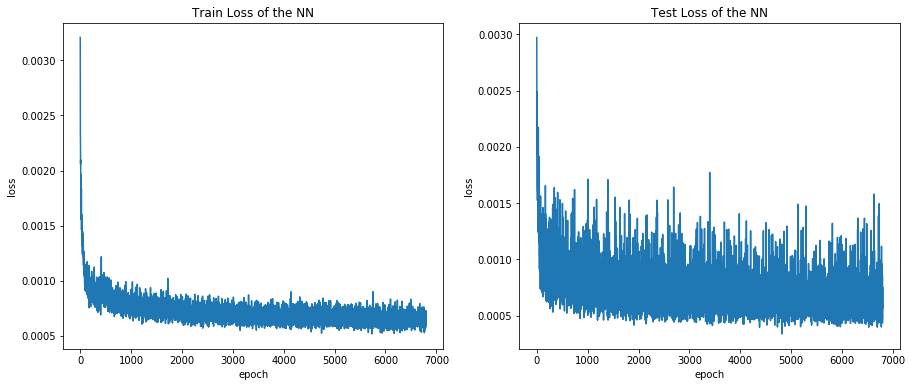

In [159]:
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(train_loss)
ax1.set_title('Train Loss of the NN')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(test_loss_sca)
ax2.set_title('Test Loss of the NN')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')

plt.show()

## Test data



In [161]:

test_images, test_outputs, gt_pts,_ = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


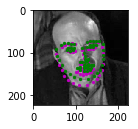

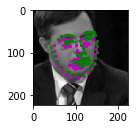

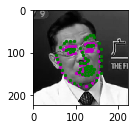

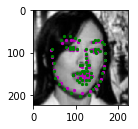

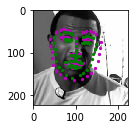

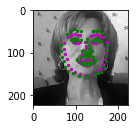

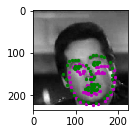

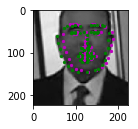

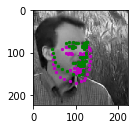

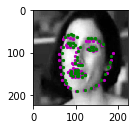

In [162]:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [163]:

model_dir = 'saved_models/'
model_name = 'Tianbai_2ndtrial.pt'

# Save model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

(32, 1, 5, 5)
[[ 0.1094344   0.08235917  0.3016848   0.46593606  0.26428106]
 [ 0.50526786  0.40251422  0.40957925  0.37096897  0.14224233]
 [ 0.23782481  0.25452733 -0.13856472 -0.08914529 -0.16652976]
 [-0.02251341  0.19737951 -0.19636175  0.08232137 -0.29564613]
 [ 0.0285064   0.10554746 -0.04623394  0.01779237 -0.11004788]]
(5, 5)


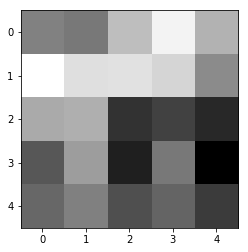

In [168]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()
print (w.shape)
filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')
plt.show()


## Filter an image to see the effect of a convolutional kernel
---

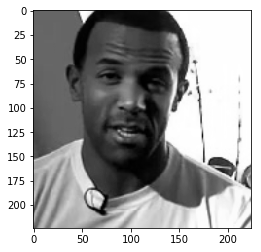

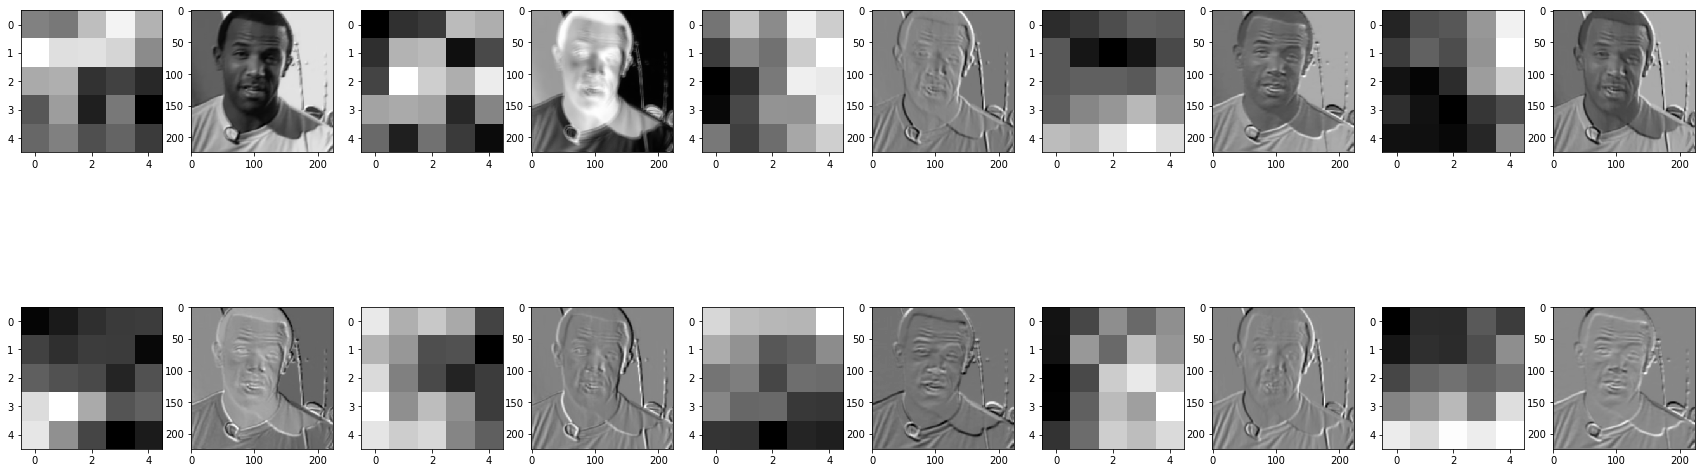

In [167]:
import cv2
##TODO: load in and display any image from the transformed test dataset
image = test_images[4].data
image = image.cpu().numpy()
image = np.transpose(image, (1, 2, 0))
image = np.squeeze(image)
#print (image.shape)
plt.imshow(image, cmap='gray')
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
w = np.squeeze(w)
fig = plt.figure(figsize = (30,10))
columns = 5*2
rows =2
for i in range(0,20):
    fig.add_subplot(2,10,i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)], cmap = 'gray')
    else:
        fil_image = cv2.filter2D(image,-1,w[int((i-1)/2)])
        plt.imshow(fil_image,cmap ='gray')

plt.show()
